# Guided project: Diving into multi-class classification via logistic regression

This is a **guided project** that we'll step through together as a class to understand multi-class logistic regression!

First, let's import some useful libraries and (optionally) set up some plot aesthetics:

In [32]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import cmocean
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


viz_style = {
    'font.family': 'sans-serif',
    'font.size':11,
    'axes.titlesize':'large',
    'axes.labelsize':'medium',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small',
    'text.color':'#5B5654',
    'axes.labelcolor':'#5B5654',
    'xtick.color':'#5B5654',
    'ytick.color':'#5B5654',
    'axes.edgecolor':'#5B5654',
    'xtick.top':False,
    'ytick.right':False,
    'axes.spines.top':False,
    'axes.spines.right':False,
    'axes.grid':False,
    'boxplot.showfliers':False,
    'boxplot.patchartist':True
}

plt.style.use(viz_style)

case_dir = '/path/to/materials'

And we're ready to go!

## Read in the data

For this project we'll be using the classic [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/Iris/). This is a very simple dataset, with only 4 features and 3 classes corresponding to different species of Iris: Setosa, Versicolour and Virginica. The features describe the length and width of the petals and sepals.

---

We'll read in the data using `sklearn`'s function `load_iris`. There are a number of other convenience functions that will allow access to other datasets, and if you're interested you can check them out here: https://sklearn.org/datasets/index.html

In [33]:
# import dataset
from sklearn.datasets import load_iris
data = load_iris()
data.keys() # summarize information in 'data'

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

Let's take a look at the target and feature names:

In [34]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [35]:
data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Our exploratory data analysis will be easier if we can work with a dataframe, so let's create one now:

In [36]:
df = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + ['species'])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


## Exploratory data analysis

Play around with the data and explore each of the 4 features! What are their distributions? How are the three classes distributed? Are any features correlated with the others? What is the relation between each feature (or combination of features) with the target variable? 

---

Recommended visualizations:
* Individual features: [Histogram](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html)
* Feature vs species class: [Box plot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)
* Relations between features and other features/target: [Pair grid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html#seaborn.PairGrid)

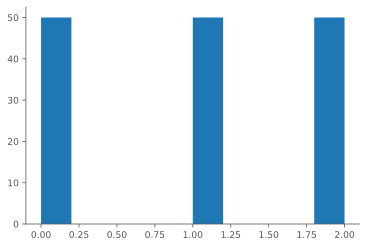

In [37]:
# target variable - note balanced classes in this case
df['species'].hist(grid=False);

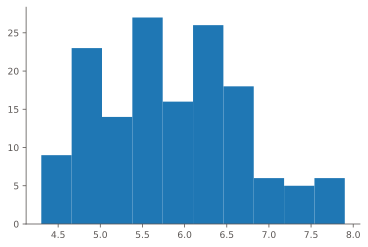

In [38]:
df['sepal length (cm)'].hist(grid=False);

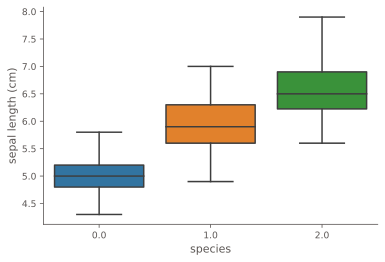

In [39]:
sns.boxplot(x='species', y='sepal length (cm)', data=df);

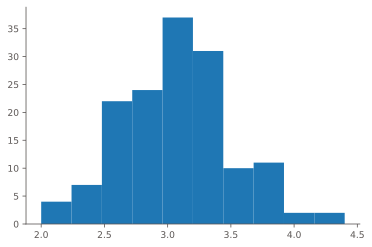

In [40]:
df['sepal width (cm)'].hist(grid=False);

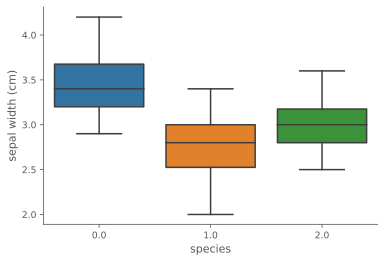

In [41]:
sns.boxplot(x='species', y='sepal width (cm)', data=df);

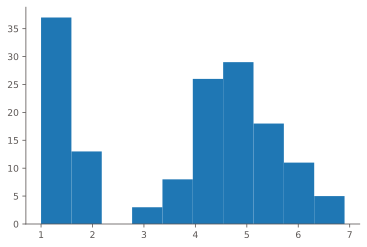

In [42]:
df['petal length (cm)'].hist(grid=False);

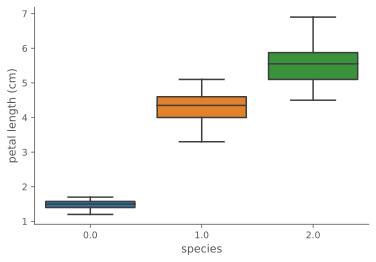

In [43]:
sns.boxplot(x='species', y='petal length (cm)', data=df);

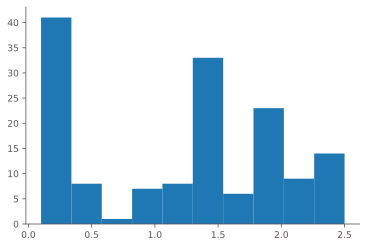

In [44]:
df['petal width (cm)'].hist(grid=False);

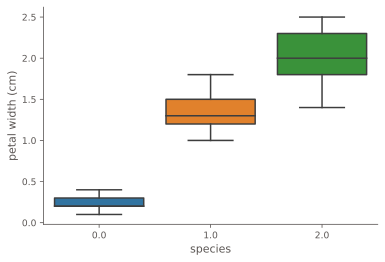

In [45]:
sns.boxplot(x='species', y='petal width (cm)', data=df);

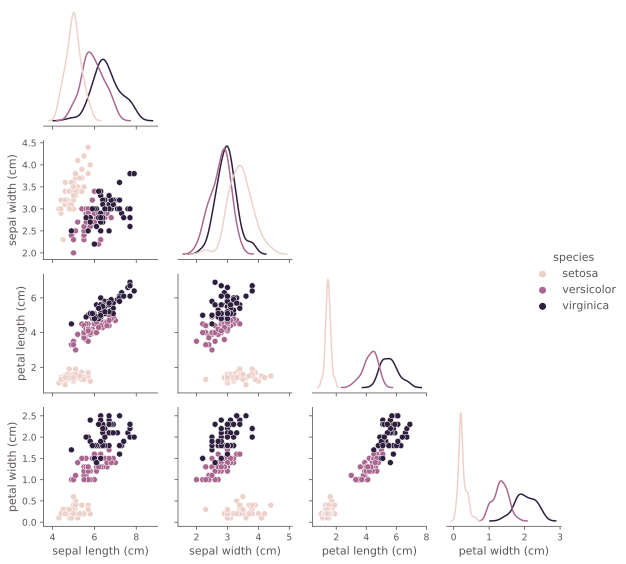

In [46]:
g = sns.PairGrid(df, diag_sharey=False, corner=True, hue='species', height=2, aspect=1.0)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot) # could also be e.g. histplot
g.add_legend()
new_labels = ['setosa', 'versicolor', 'virginica'] # optional: replace integer species with their names
for t, l in zip(g._legend.texts, new_labels): t.set_text(l);

What do you think about this dataset? Do you think these features are good predictors of the species of Iris? Why or why not?

## Training and evaluating models

### Defining training and test sets

The first thing we need to do is split our data into a training set and a test set!

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[data.feature_names], df['species'], 
                                                    random_state=0, test_size=0.25, 
                                                    stratify=df['species'])

Notice we're using the `stratify` parameter when we run `train_test_split` here. Check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html); what does this parameter do? Why might it be important here? 

### one-vs-rest

Next we'll load in the logistic regression model, the standard scaler for preprocessing, and a couple model evaluation metrics:

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

Scale your features, define your model (note we are specifying the one-vs-rest method via the `multi_class='ovr'` parameter setting), and let's see how it does:

In [49]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

clf = LogisticRegression(multi_class='ovr', random_state=0).fit(X_train_sc, y_train)

In [50]:
print('--- TRAINING SET ---')
print('Accuracy:', accuracy_score(y_train, clf.predict(X_train_sc)))

print('\n--- TEST SET ---')
print('Accuracy:', accuracy_score(y_test, clf.predict(X_test_sc)))

--- TRAINING SET ---
Accuracy: 0.9375

--- TEST SET ---
Accuracy: 0.868421052631579


One way to *visually* assess the performance of a model is by making a **confusion matrix.** For *N* classes, this is an $N\times N$ grid with the true labels on the y-axis and predicted labels on the x-axis. The value of each grid tells you how the predictions for a given class were distributed.

For example, a perfect classifier would have predict class "0" for 100% of the true class "0" samples, and similarly for class "1" and "2." We would see this as a diagonal strip of 100% in the confusion matrix, with 0% everywhere else.

In reality, though, classifiers are rarely perfect. Let's see what ours looks like:

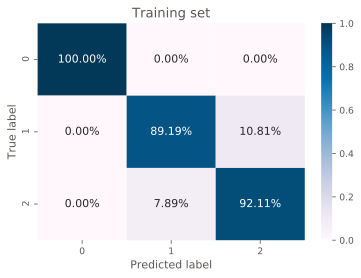

In [51]:
heatmap_train = sns.heatmap(confusion_matrix(y_train, clf.predict(X_train_sc), normalize="true"), 
                            annot=True, fmt='.2%', cmap="PuBu");
heatmap_train.set_xlabel('Predicted label')
heatmap_train.set_ylabel('True label')
heatmap_train.set_title('Training set');

What are the strengths and weaknesses of the model? Which classes does it have an easier or harder time with?

---

Make a confusion matrix for the **test set**:

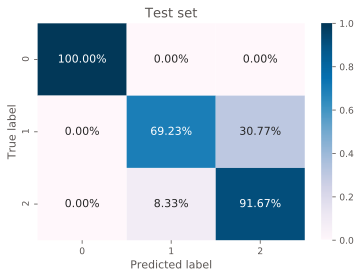

In [52]:
heatmap_test = sns.heatmap(confusion_matrix(y_test, clf.predict(X_test_sc), normalize="true"), 
                           annot=True, fmt='.2%', cmap="PuBu")
heatmap_test.set_xlabel('Predicted label')
heatmap_test.set_ylabel('True label')
heatmap_test.set_title('Test set');

What are the differences between the training and test results? Can you explain these differences?

Recall that the one-vs-rest method produces the probabilities of belong to _each_ class for every data point. We can see these via `clf.predict_proba` below:

In [53]:
clf.predict_proba(X_test_sc)

array([[8.93477925e-01, 1.06476892e-01, 4.51835150e-05],
       [7.49207520e-01, 2.50764304e-01, 2.81756020e-05],
       [9.51957507e-01, 4.80009564e-02, 4.15362385e-05],
       [8.80072079e-01, 1.19738605e-01, 1.89316276e-04],
       [5.02004838e-02, 9.21324299e-01, 2.84752173e-02],
       [3.69286895e-02, 7.77803305e-01, 1.85268005e-01],
       [6.04200719e-02, 7.95410484e-01, 1.44169444e-01],
       [7.82706063e-01, 2.17262296e-01, 3.16411796e-05],
       [1.11144119e-01, 2.85647644e-01, 6.03208238e-01],
       [1.13870399e-03, 3.39269313e-01, 6.59591983e-01],
       [8.85739199e-04, 1.11368695e-01, 8.87745566e-01],
       [4.00023302e-03, 3.49751426e-01, 6.46248340e-01],
       [6.52946266e-02, 8.87011071e-01, 4.76943023e-02],
       [1.76888171e-03, 3.53468410e-01, 6.44762708e-01],
       [2.86737248e-02, 8.61267362e-01, 1.10058913e-01],
       [9.57980305e-01, 4.19382975e-02, 8.13976875e-05],
       [7.86645952e-01, 2.13313296e-01, 4.07520959e-05],
       [1.94616589e-03, 2.36796

We might be able to do better than this though! Run a grid search to see which value of the regularization parameter `C` is best for this dataset:

In [54]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':10**np.linspace(-2,2, 11)} # feel free to change this
gs = GridSearchCV(LogisticRegression(multi_class='ovr', random_state=0), 
                  parameters).fit(X_train_sc, y_train)
print('Best params:', gs.best_params_)

print('\n--- TRAINING SET ---')
print('Accuracy:', accuracy_score(y_train, gs.predict(X_train_sc)))

print('\n--- TEST SET ---')
print('Accuracy:', accuracy_score(y_test, gs.predict(X_test_sc)))

Best params: {'C': 39.810717055349734}

--- TRAINING SET ---
Accuracy: 0.9642857142857143

--- TEST SET ---
Accuracy: 0.9736842105263158


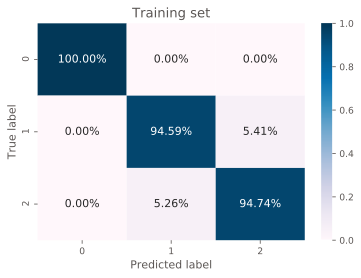

In [55]:
heatmap_train = sns.heatmap(confusion_matrix(y_train, gs.predict(X_train_sc), normalize="true"), 
                            annot=True, fmt='.2%', cmap="PuBu");
heatmap_train.set_xlabel('Predicted label')
heatmap_train.set_ylabel('True label')
heatmap_train.set_title('Training set');

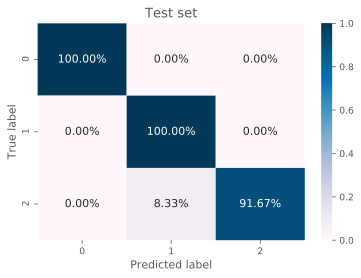

In [56]:
heatmap_test = sns.heatmap(confusion_matrix(y_test, gs.predict(X_test_sc), normalize="true"), 
                           annot=True, fmt='.2%', cmap="PuBu")
heatmap_test.set_xlabel('Predicted label')
heatmap_test.set_ylabel('True label')
heatmap_test.set_title('Test set');

What did you find? Should we apply more or less regularization to this problem to improve the accuracy? 

### multinomial

Now let's take a look at the multinomial approach. This will be similar to what you did above, except now we'll set `multi_class='multinomial'` when we define our logistic regression model:

In [57]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

clf = LogisticRegression(multi_class='multinomial', random_state=0).fit(X_train_sc, y_train)

print('--- TRAINING SET ---')
print('Accuracy:', accuracy_score(y_train, clf.predict(X_train_sc)))

print('\n--- TEST SET ---')
print('Accuracy:', accuracy_score(y_test, clf.predict(X_test_sc)))

--- TRAINING SET ---
Accuracy: 0.9553571428571429

--- TEST SET ---
Accuracy: 0.9736842105263158


And let's check out the confusion matrices for the training and test sets as well:

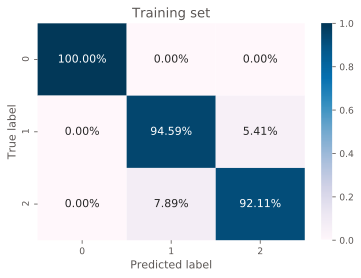

In [58]:
heatmap_train = sns.heatmap(confusion_matrix(y_train, clf.predict(X_train_sc), normalize="true"), 
                            annot=True, fmt='.2%', cmap="PuBu");
heatmap_train.set_xlabel('Predicted label')
heatmap_train.set_ylabel('True label')
heatmap_train.set_title('Training set');

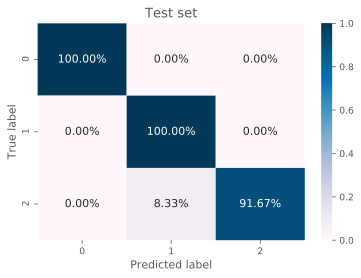

In [59]:
heatmap_test = sns.heatmap(confusion_matrix(y_test, clf.predict(X_test_sc), normalize="true"), 
                           annot=True, fmt='.2%', cmap="PuBu")
heatmap_test.set_xlabel('Predicted label')
heatmap_test.set_ylabel('True label')
heatmap_test.set_title('Test set');

How does this compare to the OVR method?

Let's run a grid search here too:

In [60]:
parameters = {'C':10**np.linspace(-2,2, 11)} # feel free to change this
gs = GridSearchCV(LogisticRegression(multi_class='multinomial', random_state=0), 
                  parameters).fit(X_train_sc, y_train)
print('Best params:', gs.best_params_)

print('\n--- TRAINING SET ---')
print('Accuracy:', accuracy_score(y_train, gs.predict(X_train_sc)))

print('\n--- TEST SET ---')
print('Accuracy:', accuracy_score(y_test, gs.predict(X_test_sc)))

Best params: {'C': 39.810717055349734}

--- TRAINING SET ---
Accuracy: 0.9732142857142857

--- TEST SET ---
Accuracy: 1.0


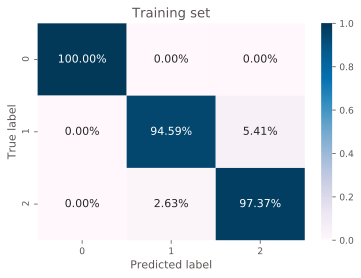

In [61]:
heatmap_train = sns.heatmap(confusion_matrix(y_train, gs.predict(X_train_sc), normalize="true"), 
                            annot=True, fmt='.2%', cmap="PuBu");
heatmap_train.set_xlabel('Predicted label')
heatmap_train.set_ylabel('True label')
heatmap_train.set_title('Training set');

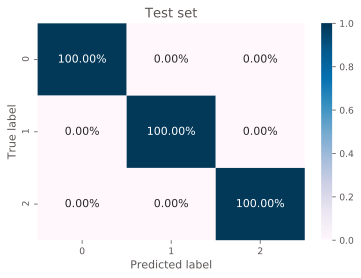

In [62]:
heatmap_test = sns.heatmap(confusion_matrix(y_test, gs.predict(X_test_sc), normalize="true"), 
                           annot=True, fmt='.2%', cmap="PuBu")
heatmap_test.set_xlabel('Predicted label')
heatmap_test.set_ylabel('True label')
heatmap_test.set_title('Test set');